In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import robot_room as robot
import draw_hmm as hmm
from histogram_filters import get_exponential_distribution_symetric, \
        get_exponential_distribution, generate_sample, run_histogram_filter, plot_estimations,\
        get_walking_noise_example_1, get_walking_noise_example_2, get_walking_noise_perfect_1,\
        get_walking_noise_perfect_3, plot_distribution, get_rayleigh_distribution, get_gaussian_distribution,\
        get_likelihood, update, prediction, plot_interactive_histogram
%matplotlib inline

# The model

The model is the same as in previous lecture [here](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/1_Histogram%20Filters.ipynb), but the main reason for the analysis of this particular case is that the observation has **additive noise**.

**Prediction step** (Same as in previous example)

$S_{n+1} = S_{n} + W$

$P(W=0) = 0.15$

$P(W=1) = 0.50$

$P(W=2) = 0.35$

**Observation step** (Additive noise)

$X_n = S_n + V$

where $S_n$ is the position of the robot and $V$ is the measurement error

So lets analyse the Observation step

# The observation $X_n = S_n + V$

## Examples of distributions of the error $V$

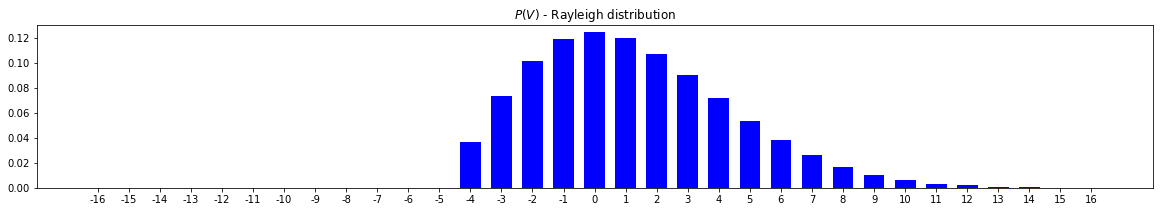

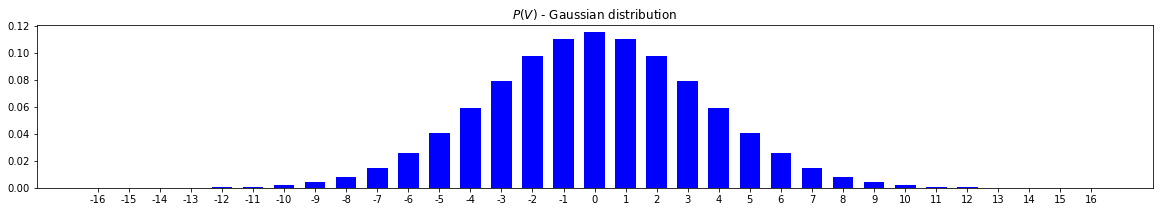

In [3]:
N = 33
center_bin = int((N+1)/2)
scale = 6 # Proportional to variance
## We will use de raileigh
observation_func = get_rayleigh_distribution

observation_1 = get_rayleigh_distribution(N= N, loc = center_bin, scale = scale)
observation_2 = get_gaussian_distribution(N= N, loc = center_bin, scale = scale)
str_indexes_V =  [str(i-center_bin+1) for i in range(N)]
plot_distribution(observation_1, title="$P(V)$ - Rayleigh distribution",str_indexes = str_indexes_V)
plot_distribution(observation_2, title="$P(V)$ - Gaussian distribution",str_indexes = str_indexes_V)

Wherever we observe, we observe the position we are plus the $V$ with one of the above distributions for example.

We will use the Rayleigh distributions in the following section because it is not symmetric and will let us emphasize the difference between the distribution of the observed variable X and the likelihood

## Distribution of the observation $X$
$X = S+V$

Lets say we that V has a Rayleigh distribution and we are in position 14.

That is, S = 14

What is the distribution of X given I am in S = 14?

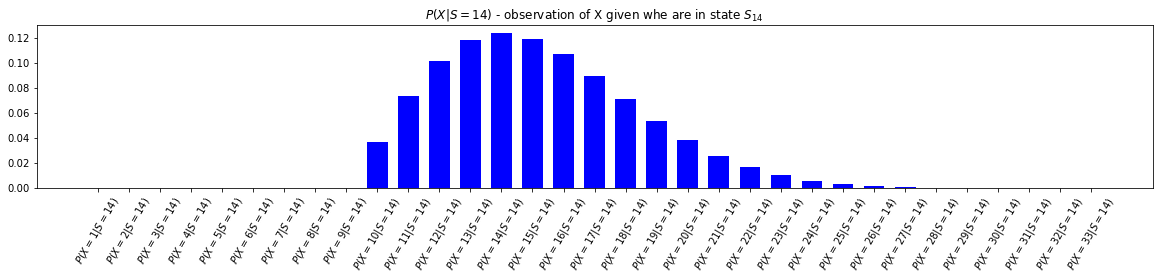

In [4]:
S = 14
observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
str_indexes_observation =  ['$P(X=%s|S=%s)$'%(int(i+1),S) for i in range(N)]
plot_distribution(observation, 
                  title="$P(X|S=%s)$ - observation of X given whe are in state $S_{%s}$"%(S, S),
                 str_indexes= str_indexes_observation, rotation = 60)

Is the above graph the likelihood of $S$?

## $\mathcal{L}(S_k|X=X_0)$ = $P(X=X_o|S_k)$

**It is not the likelihood!**

In the above example we are plotting against different values of $X$, the likelihood should be against different values of $S$

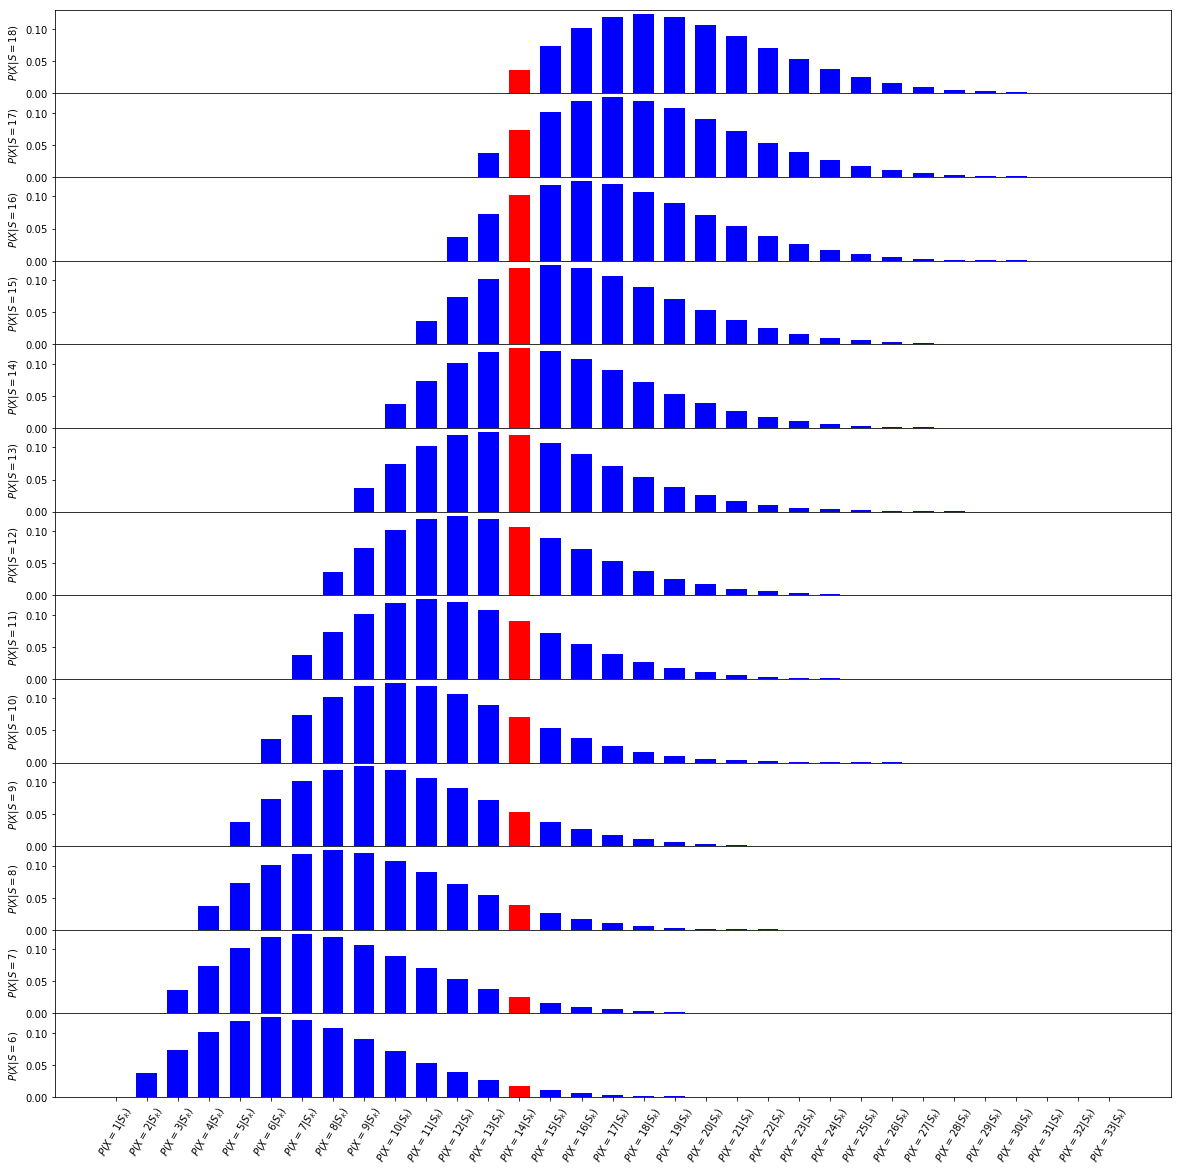

In [5]:
fig = plt.figure(figsize=(20,20))
Ss = [18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
ax = None
fig.subplots_adjust(hspace=0)
str_indexes_observation_n =  ['$P(X=%s|S_k)$'%int(i+1) for i in range(N)]
for i, S in enumerate(Ss):
    observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
    if i == 0:
        ax = plt.subplot(len(Ss),1,i+1)
    else:
        plt.subplot(len(Ss),1,i+1, sharex=ax, sharey=ax)   
    
    title="$P(X|S=%s)$"%(S)
    plt.ylabel(title)
    plot_distribution(observation, 
                  fig = fig,
                     str_indexes = -1, mark = 14)
indexes = np.linspace(1,N,N)
plt.xticks(indexes,str_indexes_observation_n, rotation=60)
plt.show()


## The likelihood $P(X|S_k)$

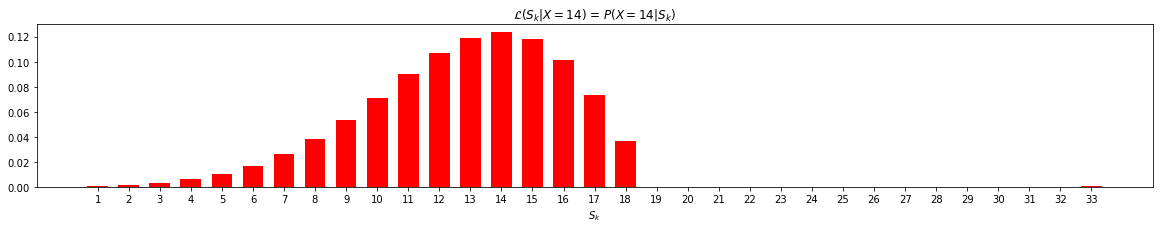

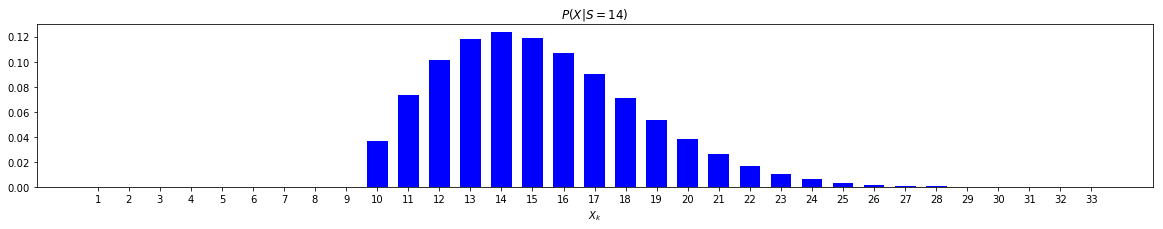

In [6]:
X = 14
S = 14
likelihood = get_likelihood(N, get_rayleigh_distribution, scale = scale)
plot_distribution(likelihood[X], color = 'r', title = "$\mathcal{L}(S_k|X=%s)$ = $P(X=%s|S_k)$"%(X,X))
plt.xlabel('$S_k$')
plt.show()
observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
plot_distribution(observation, color = 'b', title = "$P(X|S = %s)$"%(X))
plt.xlabel('$X_k$')
plt.show()

The red one is the likelihood, the blue one is the observation distribution

## The update -  $P(S_k|X) = \alpha P(X|S_k)P(S_K)$
Lets say we get an observation of X = 5

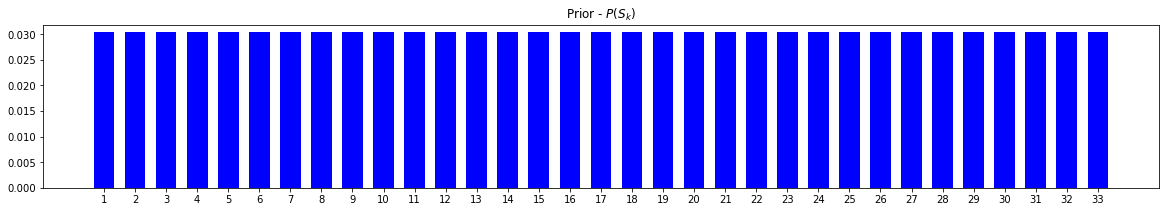

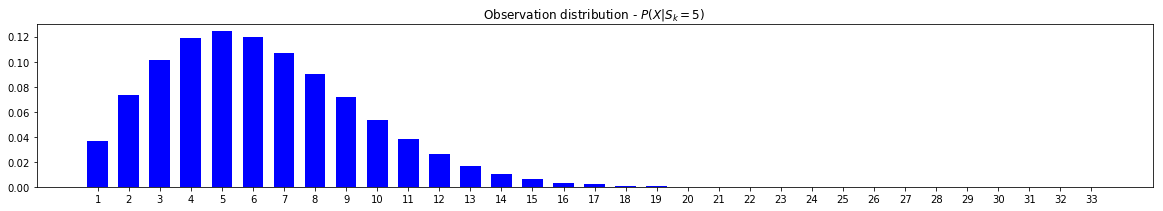

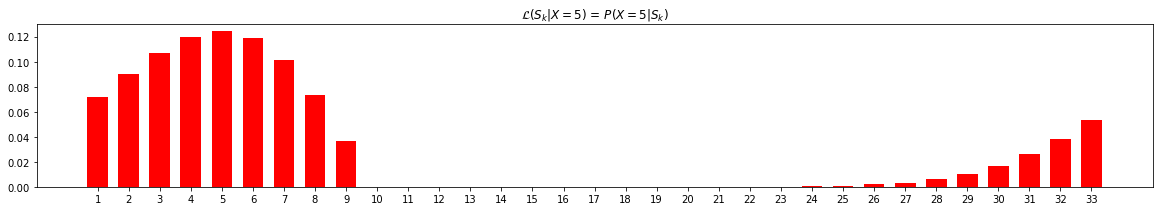

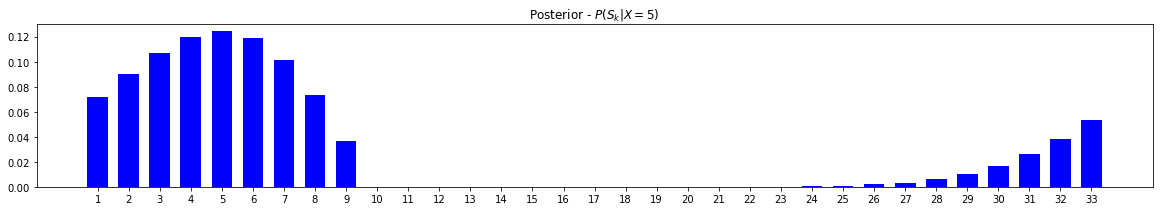

In [7]:
X = 5
p = np.ones(N)/N
posterior = update(p, X, likelihood)
plot_distribution(p, title="Prior - $P(S_k)$")
plot_distribution(observation_func(N= N, loc =X, scale = scale)
                  , title="Observation distribution - $P(X|S_k=%d)$"%X)
plot_distribution(likelihood[X], color = 'r', title = "$\mathcal{L}(S_k|X=%s)$ = $P(X=%s|S_k)$"%(X,X))
plot_distribution(posterior, title="Posterior - $P(S_k|X=%d)$"%X)

## The prediction - $S_{k-1} + W$
Whenever we want to find the distribution of the sum of 2 random variables we need to do the **convolution**

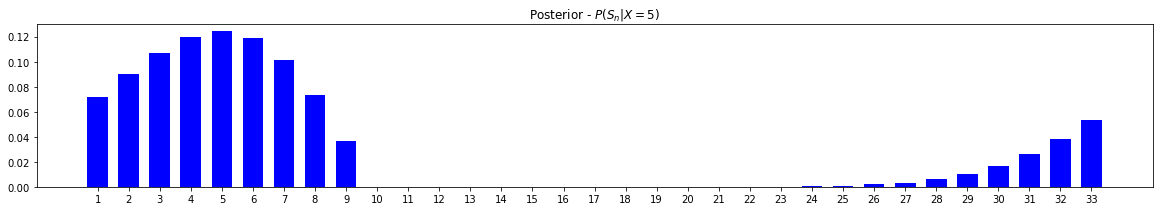

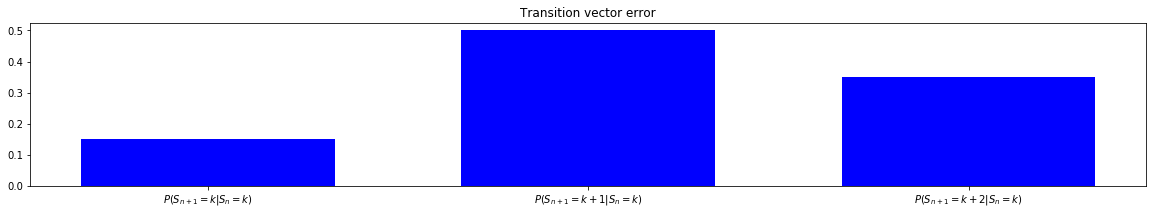

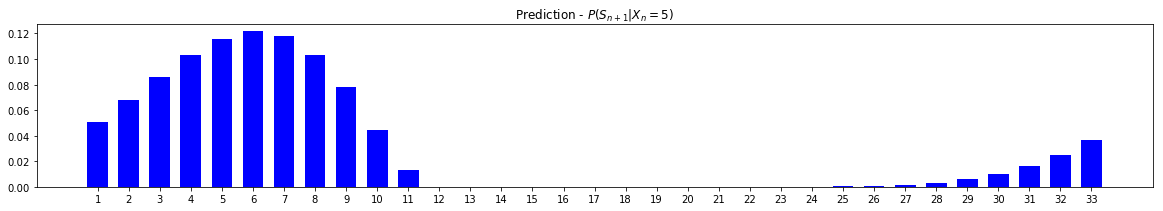

In [8]:
W = np.zeros(3)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35

str_indexes_transition =  ['$P(S_{n+1}=k|S_n=k)$', 
                           '$P(S_{n+1}=k+1|S_n=k)$', 
                           '$P(S_{n+1}=k+2|S_n=k)$']

plot_distribution(posterior, title="Posterior - $P(S_n|X=%d)$"%X)
plot_distribution(W, title="Transition vector error", str_indexes = str_indexes_transition)
predicted = prediction(posterior, W)
plot_distribution(predicted, title="Prediction - $P(S_{n+1}|X_n=%d)$"%X)

# Generate Samples and test different cases

In [9]:
# For all the examples is the same
prior = np.ones(N)/N

In [17]:
def plot_and_get_data(walking_func, observation_func, N=33, steps=20000, S=17, scale=6):
    W = walking_func(N)
    plot_distribution(W, title="Transition")
    likelihood = get_likelihood(N, observation_func, scale=scale)

    measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, 
                                                   W=W, 
                                                   initial_state=S, 
                                                   steps = steps)
    plot_distribution(likelihood[measurements[0]], title="Likelihood - $P(X=%d|S_k)$"%measurements[0])
    robot.plot_robot_room(N = N, loc = loc[-1], sample_stats = sample_stats)
    return measurements, W, likelihood, loc

## Example 1
- Rayleigh distribution
- Walking as in lecture

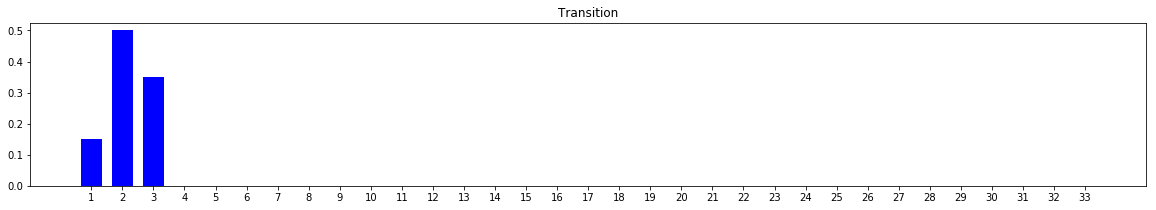

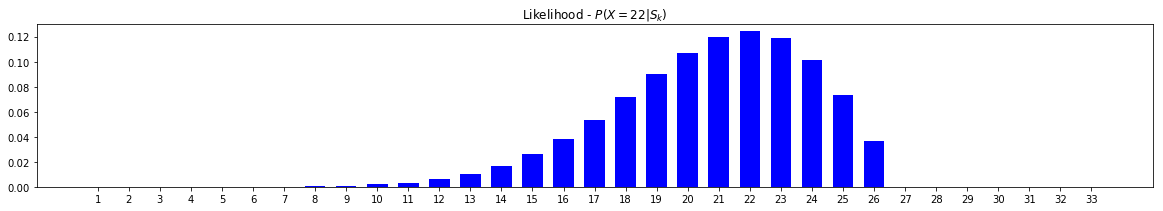

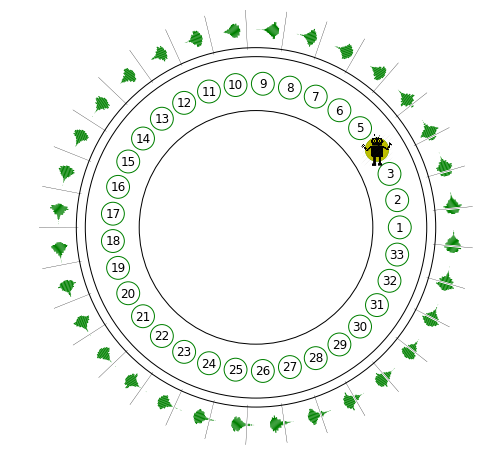

In [37]:
measurements_1, W_1, likelihood_1, loc_1 = plot_and_get_data(get_walking_noise_example_1, get_rayleigh_distribution)

In [38]:
plot_interactive_histogram(measurements_1, W_1, likelihood_1, prior, 200, 
                           initial_slider_pos = 1, real_locations=loc_1)

## Example 2
- Rayleigh distribution
- Walking perfect

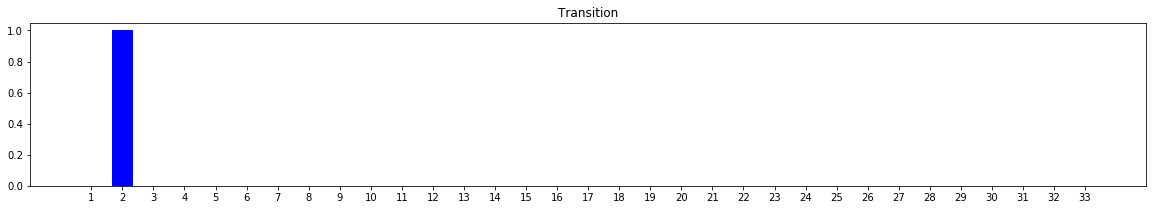

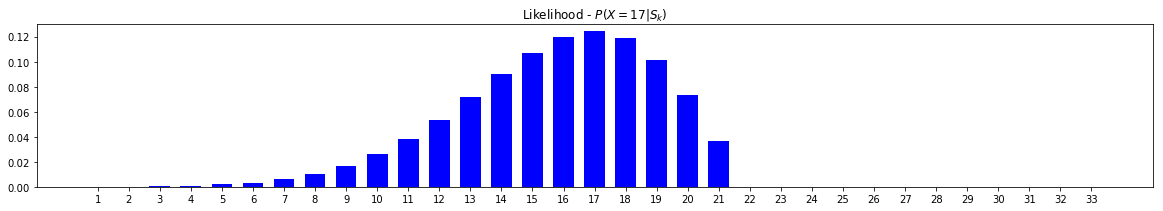

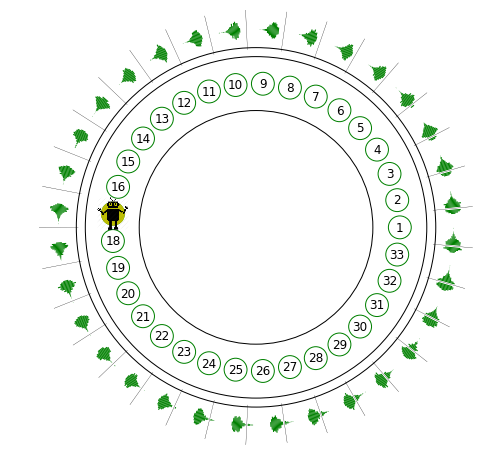

In [39]:
measurements_2, W_2, likelihood_2, loc_2 = plot_and_get_data(get_walking_noise_perfect_1, get_rayleigh_distribution)

In [40]:
plot_interactive_histogram(measurements_2, W_2, likelihood_2, prior, 200, 
                           initial_slider_pos = 1, real_locations=loc_2)

## Example 3

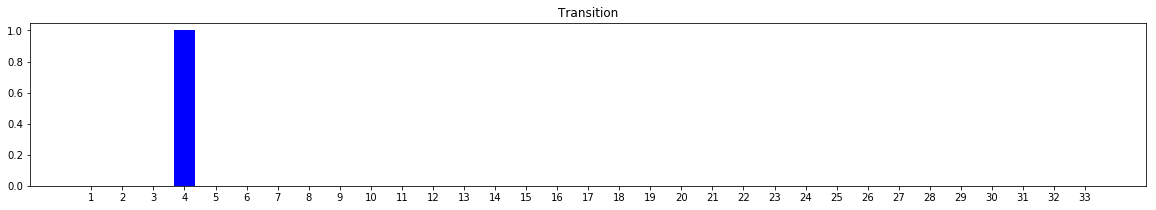

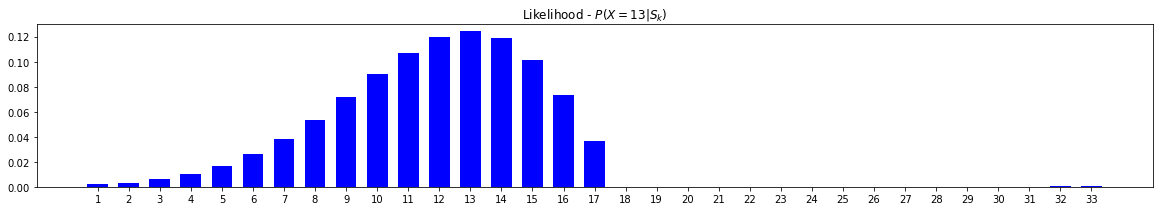

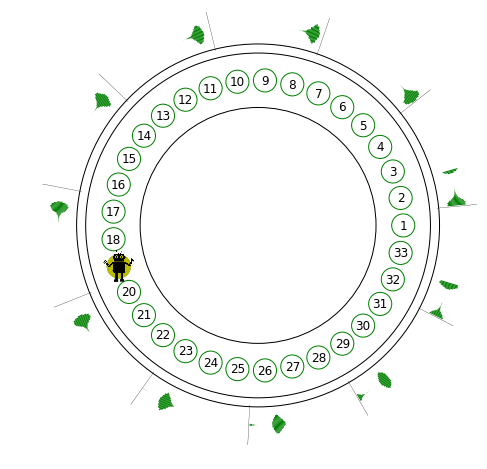

In [41]:
measurements_3, W_3, likelihood_3, loc_3 = plot_and_get_data(get_walking_noise_perfect_3, get_rayleigh_distribution)

In [42]:
plot_interactive_histogram(measurements_3, W_3, likelihood_3, prior, 100, 
                           initial_slider_pos = 1, real_locations=loc_3)

## Example 4. Getting nearer to the Kalman filter

One of the main characteristics for the Kalman filter is that both, the observation noise and the prediction noise are zero means gaussian random variables. Let's build this scenario:

**Prediction step** (Additive Gaussian Noise)

$S_{n+1} = S_{n} + 1 + W$ = $S_{n} + W_1$

**Observation step** (Additive Gaussian Noise)

$X_n = S_n + V$

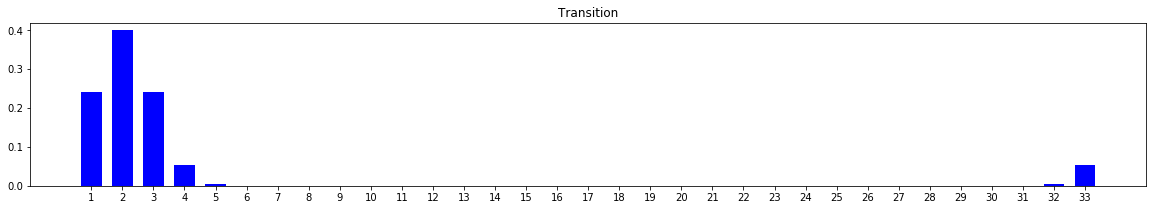

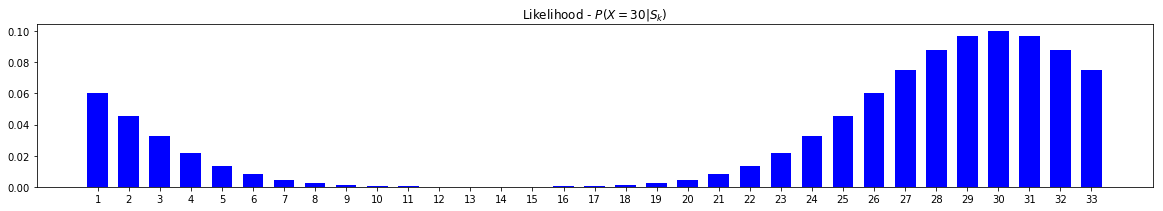

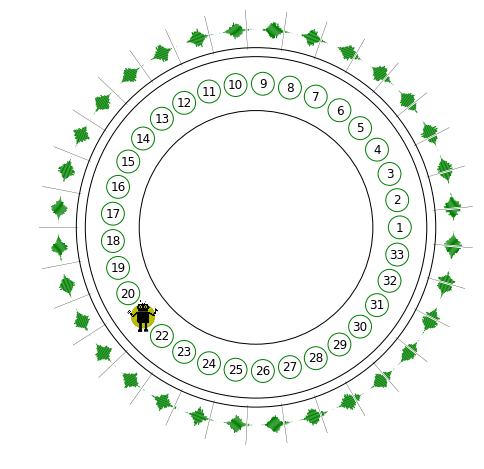

In [44]:
def get_gaussian_prediction(N = 33):
    # This emulates W_1 gaussian random variable with mean = 1
    return get_gaussian_distribution(N=N, loc=2, scale=0.5)


measurements_4, W_4, likelihood_4, loc_4 = plot_and_get_data(get_gaussian_prediction, 
                                                      get_gaussian_distribution, scale=8)

In [45]:
plot_interactive_histogram(measurements_4, W_4, likelihood_4, prior, 200, 
                           initial_slider_pos = 1, real_locations=loc_4)